In [1]:
"""!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip3 install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip3 install descartes
!pip3 install folium # Standard way """

'!apt update\n!apt upgrade\n!apt install gdal-bin python-gdal python3-gdal \n# Install rtree - Geopandas requirment\n!apt install python3-rtree \n# Install Geopandas\n!pip3 install git+git://github.com/geopandas/geopandas.git\n# Install descartes - Geopandas requirment\n!pip3 install descartes\n!pip3 install folium # Standard way '

In [1]:
!pip install folium

You should consider upgrading via the 'C:\Users\Lam Tho\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
#Importation de librairies :
import re
import folium
import requests
import zipfile 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics  import silhouette_score
from sklearn.preprocessing import OneHotEncoder

In [3]:
#Dictionnaire codePostale-coordonnées-code insee
link = "https://raw.githubusercontent.com/high54/Communes-France-JSON/master/france.json"
r = requests.get(link)
departement = pd.json_normalize(r.json())[["Code_postal","coordonnees_gps","Code_commune_INSEE"]]
departement["Code_postal"] = departement["Code_postal"].astype(str)
departement["Code_postal"] = departement["Code_postal"].apply(lambda x : "0"+x if len(x) ==4
                                                             else x)
departement["Code_commune_INSEE"] = departement["Code_commune_INSEE"].astype(str)
departement["Code_commune_INSEE"] = departement["Code_commune_INSEE"].apply(lambda x : "0"+x if len(x) ==4
                                                             else x)
departement = departement.set_index("Code_postal")
departement = departement[departement["coordonnees_gps"] != ""]
coordonnées_dict = departement.to_dict()["coordonnees_gps"]
codeinse_dict = departement.to_dict()["Code_commune_INSEE"]

link = "https://public.opendatasoft.com/explore/dataset/population-francaise-communes/download/?format=json&timezone=Europe/Berlin&lang=fr"
r = requests.get(link)
density = pd.json_normalize(r.json())
density = density[["fields.annee_recensement","fields.code_insee_commune","fields.population_totale"]]
density = density.sort_values(by = "fields.annee_recensement", ascending = False)
density = density.drop_duplicates(subset=["fields.code_insee_commune"],keep = "first")
density = density.drop(columns = ["fields.annee_recensement"])
density = density.set_index("fields.code_insee_commune")
density_dict = density.to_dict()["fields.population_totale"]

In [30]:
#Fonctions : 

#Pour déterminer les valeurs uniques d'une liste : 
def liste_unique(liste_test):
    liste_resultat = []
    if i in liste_resultat : 
        next
    else:
        liste_resultat.append(i)
    return liste_resultat

#Pour Déterminer les coordonnées en fonction du code postale : 
def coordonnées(code_postal):
    if code_postal in coordonnées_dict :
        return [coordonnées_dict[code_postal].split(",")[0],coordonnées_dict[code_postal].split(",")[1]]
    else:
        return None
        
#Pour Déterminer le code INSEE en fonction du cbode postale : 
def codeInse(code_postal):
    if str(code_postal) in codeinse_dict :
        return codeinse_dict[str(code_postal)]
    else:
        return None
    
#Pour Déterminer la population en fonction du code 
def Population(code_insee):
    global liste 
    if str(code_insee) in density_dict :
        if density_dict[str(code_insee)] > 5000:
            return 1
        else:
            return 0
    elif (str(code_insee)[:2] == "75") | (str(code_insee)[:2] == "13") | (str(code_insee)[:2] == "69"):
        return 1
    else:
        return 0
    
#Pour le prix : 
def Prix(price,campaign_id,product_id):
    if campaign_id >=20:
        if str(product_id) in ["479","181"]:
            return price*100
        else:
            return price
    else:
        return price*100
    
#Matière : 
def naturel(liste):
    naturel = ['coton','lin','laine','cachemire','soie','caoutchouc','alpaga','cuir','chanvre','angora','tricotine', 'suède', 
           'raffia', 'métal', 'laiton', 'konjac', 'karité', 'jute', 'huiles', 'hêtre', 'daim', 'chèvre', 'chêne', 'bouleau',
           'bois', 'aluminium', 'aluminium acier', 'acier', 'acier laqué', 'abeille', 'coco', 'huile', 'denim', 'dentelle',
          'guipure', 'huiles', 'jersey', 'textile', 'tissu', 'toile', 'tweed', 'viscose']
    compteur = 0
    for i in liste:
        if i.lower() in naturel:
            compteur = 1
    if compteur > 0:
        return 1
    else : 
        return 0

def synthetique(liste):
    synthetique = ['acrylique', 'caoutchouc', 'cuir végétal','denim', 'dentelle', 'fausse fourrure', 'guipure',
                   'jersey','nylon','plastique','plexi','polyamide','polyester','polyurethane','polyuréthane', 'PU', 
                   'PVC', 'stratifié', 'stratifié imprimé marbre', 'synthétique', 'textile', 'tissu', 'toile', 'tweed',
                   'vinyle', 'viscose', 'elasthanne']
    compteur = 0
    for i in liste:
        if i.lower() in synthetique:
            compteur = 1
    if compteur > 0:
        return 1
    else : 
        return 0

def ecolabel(liste):
    label = ['gots','oeko-tex', 'oeko tex', 'naturleder','eu ecolabel','origine france garantie', 'eco tex','eco-tex',
             'bio', 'recyclé', 'biologique', 'responsable', 'responsables', 'écoresponsable', 'éco-responsable',
             'upcyclé', 'vegan', 'vegane']
    compteur = 0
    for i in liste:
        if i.lower() in label:
            compteur = 1
    if compteur > 0:
        return 1
    else : 
        return 0

#Campagne : # à rajouter les campagnes_id au fur et à mesure que la table sera update
def typeCampagne(numero):
    cosmetique = [33,77]
    deco = [8,20,43,76]
    mode = [2,4,6,7,22,23,25,26,27,28,30,34,35,36,37,38,39,40,41,42,78]
    if numero in cosmetique :
        return "Cosmetique"
    elif numero in deco:
        return "Deco"
    elif numero in mode:
        return "Mode"

#Couleur : 
def vif(color):
    color_vif = ['multicolor','doré','argenté','bleu algue','bleu canard','bleu lagon','bleu turquoise','jaune',
                 'jaune clair','jaune pastel','jaune moutarde','jaune safran','marron terracotta','orange','rose',
                 'rose framboise','rose fuchsia','rouge','rouge corail','rouge brique','rouge cerise','vert',
                 'vert clair','vert menthe','vert olive','vert pistache','vert sapin','violet lavande',
                 'violet lila','fleurs','mauve','brun roux',"vert d'eau",'fuschia','parme','lila','lavande',
                 'moutarde','corail','safran','terrer de sienne','bandana rouge','touches multicolors',
                 "menthe a   l'eau",'rose multicolore','olive','rum punch','rose 77','schiap','unicorn',
                 'tie dye','rose 01','719 love bouquet','n92 rouge caftan','25 goldie red',
                 'n205 - fushia irresistible - fini mat lumineux','348 coral peony - satin','cerise n107',
                 'strawberry pink 02','pistache','mauve clair','lavande','jaune pastel','argenté clair','rose poudrée',
                 'imprimé géométique jaune','jaune tartan','rose rouge','terracotta','rose flash','algue']
    compteur = 0
    for i in color:
        if i.lower() in color_vif:
            compteur = 1
    return compteur

def neutre(color):
    color_neutre = ['sans (transparent)','beige','beige sable','beige bouleau','beige camel','beige fauve','beige nude','beige chene','beige naturel',
                    'beige hetre','blanc','blanc cassé','bleu','bleu clair','bleu ciel','bleu pastel','bleu denim','bleu foncé','bleu profond',
                    'bleu klein','bleu marine','gris','gris clair','gris souris','gris foncé','gris taupe','marron',
                    'marron caramel','marron cognac','marron fauve','marron noisette','marron chocolat','noir','rose clair',
                    'rose saumon','rouge bordeaux','vert kaki','violet prune','fauvre','hêtre','bouleau',
                    'naturel','sable','léopard','jean','nude','bleu gris','bordeaux','ecru','noir délavé',
                    'camel','bleu délavé','bordeaux foncé','saumon','taupe','bandana fleur bleue','gris anthracite',
                    'bleu jean','croco marron','zèbre marron','cognac','matt','14 beige copacabana','brun nude 211',
                    'au naturel','marron camel','noir croco','noir semi-verni','marron croco','daim brun','brun',
                    'prune','noir blanc','blanc noir','noir beige','noir bleu','bleu blanc','bois clair','lin',
                    'marine']
    compteur = 0
    for i in color:
        if i.lower() in color_neutre:
            compteur = 1
    return compteur

#Style Préférence : 
def casual(style):
    style1 = ['Casual', 'Urbancool', 'Streetwear', 'Kawaii']
    compteur = 0
    for i in style:
        if i in style1:
            compteur += 1
    return compteur

def chic(style):
    style2 = ['Chic', 'Smart', 'Working Girl']
    compteur = 0
    for i in style:
        if i in style2:
            compteur += 1
    return compteur

def rock(style):
    style3 = ['Rock', 'Gothique']
    compteur = 0
    for i in style:
        if i in style3:
            compteur += 1
    return compteur

def engagee(style):
    style4 = ['Engagée', 'Made in France']
    compteur = 0
    for i in style:
        if i in style4:
            compteur += 1
    return compteur
    
def fatale(style):
    style5 = ['Fatale']
    compteur = 0
    for i in style:
        if i in style5:
            compteur += 1
    return compteur

def boheme(style):
    style6 = ['Bohême', 'Romantique']
    compteur = 0
    for i in style:
        if i in style6:
            compteur += 1
    return compteur

def vintage(style):
    style7 = ['Vintage']
    compteur = 0
    for i in style:
        if i in style7:
            compteur += 1
    return compteur

def inconnu(style):
    style8 = ['Inconnu']
    compteur = 0
    for i in style:
        if i in style8:
            compteur += 1
    return compteur

#Brand Préférence : 
def access_brand(marque):
    access_brand = ["monoprix beauté"]
    compteur = 0
    for i in marque:
        if i.lower() in access_brand:
            compteur += 1
    return compteur

def mass_brand(marque):
    mass_brand = ["sephora","l'oréal","nocibé","maybelline","bourjois","marionnaud","birchbox","cosmopolitan",
                  "glossier","mercu handy","bleach london"]
    compteur = 0
    for i in marque:
        if i.lower() in mass_brand:
            compteur += 1
    return compteur

def premium_brand(marque):
    premium_brand = ["nuxe","benefit cosmetics","l'occitane","origins","black up","bumble & bumble","st tropez",
                     "les petits prodiges","prescription lab","mimitika","claus porto"]
    compteur = 0
    for i in marque:
        if i.lower() in premium_brand:
            compteur += 1
    return compteur

def hdg_brand(marque):
    hdg_brand = ["urban decay","rituals","nars","opi","kerastase","essie","bobbi brown","payot","aries",
                 "esthederm","bkr"]
    compteur = 0
    for i in marque:
        if i.lower() in hdg_brand:
            compteur += 1
    return compteur

def prestige_brand(marque):
    prestige_brand = ["fenty beauty","dior backstage","kenzo","lacoste","clarins","clinique","huda beauty",
                      "burberry","cacharel","make up forever","paco rabanne","marc jacobs beauty",
                      "lolita lempicka","erborian","tom ford","filorga","talika","molinard"]
    compteur = 0
    for i in marque:
        if i.lower() in prestige_brand:
            compteur += 1
    return compteur

def luxe_brand(marque):
    luxe_brand = ["chanel", "yves saint laurent", "lancome", "guerlain", "givenchy", "gucci", 
                  "estée lauder", "nina ricci", "prada", "lancaster", "laneige", "sisley", "lanvin", 
                  "la mer", "elizabeth arden", "acquia di parma", "la prairie", "issey miyake", 
                  "juliette has a gun", "goutal", "shu uemura", "kilian"]
    compteur = 0
    for i in marque:
        if i.lower() in luxe_brand:
            compteur += 1
    return compteur

def bio_brand(marque):
    bio_brand = ['corine de farme','mademoiselle bio','sanoflore','cattier','havana','pur aloe',
                 'les fleurs de bach','egyptian magic','absolution','decleor','melvita','dr hauschka',
                 'herb essentials','abyssea','jonzac','akane','argiletz','lov organic','beliflor','leonor greyl',
                 'centifolia','florame','les huilettes','patyka','finessence','bivouak','les poulettes',
                 'lamazuna','pachamamai','greenma','oden','boulado','mamaki','kure bazaar','karethic']
    compteur = 0
    for i in marque:
        if i.lower() in bio_brand:
            compteur += 1
    return compteur

#Like : 
def dislike(action_fact,valeur_colonne):
    if action_fact == 1:
        return valeur_colonne
    else:
        return 0
    
def like(action_fact,valeur_colonne):
    if action_fact == 0:
        return valeur_colonne
    else:
        return 0
    
# Fashion preferences
def access_mode(marque):
    access_mode = ["H&M", "Pimkie", "PULL&BEAR", "Asos", "Undiz", "Jennyfer", "Camaieu", "C&A", "Kaporal", "Hollister",
                  "Missguided", "Jack & Jones", "Urban Outfitters", "Vero Moda", "Blancheporte", "See u Soon",
                  "Stradivarius", "Shein", "Bershka", "Cache Cache", "Boohoo", "Kiabi", "Bonobo", "Adopt", "Gemo",
                  "Decathlon", "La Halle", "Bizzbee", "La Redoute", "New Look", "Monoprix"]
    compteur = 0
    for i in marque:
        if i in access_mode:
            compteur += 1
    return compteur

def mass_market(marque):
    mass_market = ["Etam", "Adidas", "Zara", "Nike", "Levi's", "adidas Originals", "Converse", "Etam Lingerie", "Vans",
                  "Zalando","Puma", "Promod", "Naf Naf", "Dr. Martens", "le coq sportif", "Fila", "Reebok", "Eastpak",
                  "Teddy Smith", "Asics","Le Temps Des Cerises", "Ikks", "Les Tropéziennes", "Pepe Jeans", "Champion",
                  "Lancaster", "Quiksilver","Lee Cooper", "Kappa", "Princesse tam.tam", "Superdry", "Roxy", "Gap",
                  "Birkenstock", "Rip Curl", "Gambettes Box", "Passionata", "Under Armour", "Oysho", "Lookiero", "O'Neill",
                  "Scotch & Soda", "Steve Madden", "Oakley", "Paul Hewitt", "Juicy Couture", "Superga", "Miss Selfridge",
                  "Blugirl", "J.CREW", "Speedo", "Thecloset", "Melissa", "JJ brands", "Mango", "Calzedonia", "Armand Thierry",
                  "PrettyLittleThing", "Dim", "Desigual", "Ange", "Courir", "Darjeeling", "Kookai", "Lollipops",
                  "American Eagle", "Caroll", "Esprit", "Karl Marc John", "Maison 123", "New Balance", "Ellesse Tanker",
                  "Armor-Lux", "Crocs", "Eram", "Morgan", "Topshop", "Geox", "Okaidi", "Abercrombie", "Circus", "Swatch",
                  "Jonak"]
    compteur = 0
    for i in marque:
        if i in mass_market:
            compteur += 1
    return compteur

def premium_mode(marque):
    premium_mode = ["Calvin Klein", "Lacoste", "Tommy Hilfiger", "Diesel", "Michael Kors", "Polo Ralph Lauren",
                  "Zadig & Voltaire", "Cacharel", "Karl Lagerfeld", "Maje", "The Kooples", "Marc Jacobs", "Ba&sh",
                  "Sandro", "Petit Bateau", "Love Moschino", "Repetto", "Victoria Beckham", "Pink", "Carhartt",
                  "Sézane", "Porsche Design", "See by Chloé", "Paul & Joe", "Red Valentino", "Bocage", "DKNY", "Gas Bijoux",
                  "Golden Goose", "Le Tanneur", "Claudie Pierlot", "Bel Air", "Liu Jo", "Bazar Deluxe", "Coach", "Coccinelle",
                  "Furla", "Le Mont St Michel" , "Hogan", "Veja", "Les Petites", "Volcom", "K-Way", "Patagonia",
                  "Fred Perry", "Antik Batik", "J brands", "Marc O'Polo", "Berenice", "Reminiscence", "Ted Baker",
                  "Pinko", "Moon Boot", "Ami Paris", "Chiara Ferragni", "A.P.C.", "Colmar", "Stussy", "BAPE", "Anne & Valentin",
                  "La Martina", "L'Eclaireur", "AllSaints", "Bellerose", "PAIGE", "Kate spade", "Karen Millen", "IRO", "Bally",
                  "Church's", "Asphalte", "Polène", "Etoile", "From Future", "Amen", "Charles Jourdan", "Amélie Pichard",
                  "Tory Burch", "RouJe", "Each X Other", "be blumarine", "Axel Arigato", "Herschel Supply Co.",
                  "Barbour", "Ancient Greek Sandals", "MM6", "Notify", "ANINE BING", "Jim Rickey", "Belstaff", "Clergerie",
                  "Zespa", "Kurt Geiger", "Ambra Maddalena", "Anya Hindmarch", "Shourouk", "House of Holland",
                  "Majestic Filatures", "Aurelie Bidermann", "Hogan Rebel", "Vanessa Seward", "R.S.V.P.", "Charli Cohen",
                  "Falke", "By Malene Birger", "Patrizia Pepe", "Tosca Blu", "Spanx", "Pandora", "Timberland", "Off-White",
                  "Balzac", "Swarovski", "Camper", "Aubade", "Ash", "Ray-Ban", "G Star", "Kiwi Saint Tropez", "Miss Sixty",
                  "CamperLab", "Banana Moon", "Clarks", "Aigle", "Kickers", "La Jaquette", "Lululemon", "Ugg",
                  "Christine Laure", "Parisienne et alors", "Des petits hauts", "Free Lance"]
    compteur = 0
    for i in marque:
        if i in premium_mode:
            compteur += 1
    return compteur

def hdg_mode(marque):
    hdg_mode = ["Longchamp", "Kenzo", "BOSS", "Hugo Boss", "The North Face", "Giorgio Armani", "Lancel", "Off White",
                  "Canada Goose", "Paul Smith", "Acne Studios", "Tom Ford", "Max Mara", "La Perla", "Vanessa Bruno",
                  "Cerruti 1881", "Moncler", "Sonia Rykiel", "Escada", "Guy Laroche", "Carolina Herrera", "Agent Provocateur",
                  "Le Petite Robe Di Chiara Boni", "7 For All Mankind", "Alberta Ferretti","Plein Sud", "Christopher Kane",
                  "MCM", "Agnelle", "AKIRA NAKA", "Pyrenex", "Diane von Furstenberg", "Alain Mikli", "Agnona", "Raf Simons",
                  "Charlotte Olympia", "Borsalino", "Zucca", "Barbara Bui", "K. Jacques", "Jacomo", "Blumarine", "Paule Ka",
                  "Paul Andrew", "Alexandra Golovanoff", "Zac Posen", "Botier", "Rag & Bone", "Marni", "Olympia Le-Tan",
                  "JW Anderson", "Fusalp", "Tom Dixon", "Ambush", "Malo", "Harris Wharf London", "Opening Ceremony", "MSGM",
                  "Sacai", "Etro", "Pleats Please Issey Miyake", "Marlies Dekkers", "Panoply", "Le Gramme", "Tsumori Chisato",
                  "Equipment", "Theory", "Derek Lam", "Smythson", "Sartore", "Vetements", "Aalto", "Isabel Marant"]
    compteur = 0
    for i in marque:
        if i in hdg_mode:
            compteur += 1
    return compteur

def prestige_mode(marque):
    prestige_mode = ["Chloé", "Jean Paul Gaultier", "Burberry", "Christian Louboutin", "Alexander McQueen", "Versace",
                     "Jacquemus", "Jimmy Choo", "Cavalli", "Mugler", "Dsquared2", "Stella McCartney", "Giuseppe Zanotti",
                     "Alexander Wang", "Issey Miyake", "Roberto Cavalli", "3.1 Phillip Lim", "Mulberry", "Rochas",
                     "Vivienne Westwood", "Salvatore Ferragamo", "Sergio Rossi", "Maison Margiela", "Alexa Chung", "Tod's",
                     "Baldinini", "Emilio Pucci", "Missoni", "Alexandre Vauthier", "Hervé Leger", "Leonard", "Donna Karan",
                     "Yohji Yamamoto", "Jil Sander", "Brioni", "Rick Owens", "Proenza Schouler", "Nicholas Kirkwood",
                     "Ann Demeulemeester", "Vanrycke", "Dice Kayek"]
    compteur = 0
    for i in marque:
        if i in prestige_mode:
            compteur += 1
    return compteur

def luxe_mode(marque):
    luxe_mode = ["Chanel", "Dior", "Balenciaga", "Lous Vuitton", "Gucci", "Hermès", "Givenchy", "Valentino", "Fendi",
                 "Prada", "Saint Laurent", "Balmain", "Céline", "Bvlgari", "Miu Miu", "Van Cleef & Arpels", "Bottega Veneta",
                 "Elie Saab", "Boucheron", "Pierre Hardy", "Brunello Cucinelli", "Loewe", "Zuhair Murad", "Emanuel Ungaro",
                 "Ermenegildo Zegna", "Maison Ullens", "Pomellato", "Louis Vuitton"]
    compteur = 0
    for i in marque:
        if i in luxe_mode:
            compteur += 1
    return compteur

def vintage_mode(marque):
    vintage_mode = ["Jean Paul Gaultier Pre-Owned", "Chanel Pre-Owned", "Rolex Pre-Owned", "John Galliano Pre-Owned",
                    "JC de Castelbajac Pre-Owned", "Dries Van Noten Pre-Owned"]
    compteur = 0
    for i in marque:
        if i in vintage_mode:
            compteur += 1
    return compteur

def eco_responsable_mode(marque):
    eco_responsable_mode = ["Stella McCartney", "Le Chapeau", "GANNI", "Ekyog", "Hopaal", "Vanda Jacintho","Patagonia",
                            "Alchemist","Atelier Unes", "Re/Done", "N'go", "Chaussettes orphelines", "1083"]
    compteur = 0
    for i in marque:
        if i in eco_responsable_mode:
            compteur += 1
    return compteur

# Fonction pour déterminer le like_price
def mean1(like_price):
    somme=0
    compte=0
    moy=0
    for i in like_price:
        if i >0:
            somme +=i
            compte+=1
            moy=somme/compte
    return moy

In [31]:
df = pd.read_csv('20220201230731-all_campaigns.csv', sep=',')
df

C:\Users\Lam Tho\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,campaign_id,created at,action,product id,product name,product reference,color,material,price,user id,email,birthdate,zipcode,styles preferences,fashion preferences,brands preferences
0,1,7,2020-06-25 10:41:05 UTC,dislike,92,Pull court,303031156285,blanc,acrylique,29.0,2,e@e.com,1996-07-30,NaN,"Casual, Chic, Rock","Nike, Adidas, adidas Originals","Absolution, Abyssea"
1,3,7,2020-06-25 10:41:20 UTC,like,93,Pull à manches longues,303031156286,vert,acrylique,20.0,2,e@e.com,1996-07-30,NaN,"Casual, Chic, Rock","Nike, Adidas, adidas Originals","Absolution, Abyssea"
2,4,7,2020-06-25 10:41:24 UTC,like,94,Pull à manches ballon,303031156287,bleu,polyester,20.0,2,e@e.com,1996-07-30,NaN,"Casual, Chic, Rock","Nike, Adidas, adidas Originals","Absolution, Abyssea"
3,5,7,2020-06-25 10:41:37 UTC,dislike,95,Pull oversize,303031156288,rose,acrylique,25.0,2,e@e.com,1996-07-30,NaN,"Casual, Chic, Rock","Nike, Adidas, adidas Originals","Absolution, Abyssea"
4,6,7,2020-06-25 10:41:51 UTC,like,96,Cardigan,303031156291,rouge,nylon,59.0,2,e@e.com,1996-07-30,NaN,"Casual, Chic, Rock","Nike, Adidas, adidas Originals","Absolution, Abyssea"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278395,293775,80,2022-02-01 16:54:01 UTC,like,942,Ecocert (minimum 70% de fibres naturelles ou r...,Confiance,NaN,NaN,NaN,3886,ramarojaonaangie@yahoo.fr,1980-06-06,14700.0,"Smart, Chic, Bohême, Urbancool, Working Girl","Jennyfer, Prada, Ralph Lauren, Kenzo, Chanel, ...","Huda Beauty, Burberry, Chanel, Dior Backstage,..."
278396,293776,80,2022-02-01 17:22:48 UTC,dislike,939,Oeko-Tex 100 (textiles sans produits toxiques),Connait,NaN,NaN,NaN,2463,mrgx19@gmail.com,1995-01-15,19500.0,"Casual, Bohême","Marc Jacobs, Promod, Camaieu, Undiz, Etam, Jim...","Sephora, OPI, Clarins, Guerlain, L'Occitane, M..."
278397,293778,80,2022-02-01 17:22:52 UTC,dislike,941,Ecocert (minimum 70% de fibres naturelles ou r...,Connait,NaN,NaN,NaN,2463,mrgx19@gmail.com,1995-01-15,19500.0,"Casual, Bohême","Marc Jacobs, Promod, Camaieu, Undiz, Etam, Jim...","Sephora, OPI, Clarins, Guerlain, L'Occitane, M..."
278398,293779,80,2022-02-01 17:22:54 UTC,like,943,GOTS (minimum 75% de fibres certifiées biologi...,Connait,NaN,NaN,NaN,2463,mrgx19@gmail.com,1995-01-15,19500.0,"Casual, Bohême","Marc Jacobs, Promod, Camaieu, Undiz, Etam, Jim...","Sephora, OPI, Clarins, Guerlain, L'Occitane, M..."


In [32]:
from IPython.display import display
#pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [33]:
#Conversion :
df["birthdate"] = pd.to_datetime(df["birthdate"])
df["zipcode"] = df["zipcode"].astype(str)

In [34]:
#Valeurs manquantes : 
df['material'].fillna('Inconnu', inplace = True)
df['styles preferences'].fillna('Inconnu', inplace = True)
df['brands preferences'].fillna('Inconnu', inplace = True)
df['fashion preferences'].fillna('Inconnu', inplace = True)

In [35]:
#Supprimer les lignes/colonnes obseletes : 
df = df[(df['email']!='e@e.com') &
        (df['email']!='aabiaad@netvariant.com') &
        (df['email']!='ea7@test.com') &
        (df['email']!='hello@praedicters.com') &
        (df['email']!='slachats@yopmail.com')]
df.dropna(subset = ['color'], inplace = True)  # Rediscuter si utile ou si remplacer par inconnu (puis ne pas mettre +1 au groupby)
df.dropna(subset = ['price'], inplace = True)  # Rediscuter si utile ou si remplacer par inconnu (puis ne pas mettre +1 au groupby)

df = df.drop(columns = ["product reference"])

<ipython-input-35-23761b2ac318>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset = ['color'], inplace = True)  # Rediscuter si utile ou si remplacer par inconnu (puis ne pas mettre +1 au groupby)
<ipython-input-35-23761b2ac318>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset = ['price'], inplace = True)  # Rediscuter si utile ou si remplacer par inconnu (puis ne pas mettre +1 au groupby)


In [36]:
#Modification des valeurs : 
#Zipcode : 
df['zipcode'].replace('17 Ru', '56600', inplace=True)
df['zipcode'].replace('nan', 'Inconnu', inplace=True)
df["zipcode"] = df["zipcode"].apply(lambda x : x.replace(".0",""))
df['zipcode'].replace('1', '75', inplace=True)
df["zipcode"] = df["zipcode"].apply(lambda x : "0" + x if len(x) == 4 else
                                                 x + "001" if x == 75 else
                                          x[0:2]+"000" if len(x) == 3 else 
                                             x + "000" if len(x) == 2 else x)
#Price : 
df["price"] = np.vectorize(Prix)(df["price"], df["campaign_id"],df["product id"])

#Matériaux:
searchfor = [',', ';', 'et', '&','%']   
df_mixte = df[df['material'].str.contains('|'.join(searchfor))] 
df_unique = df[~df['material'].str.contains('|'.join(searchfor))]
df_unique.loc[df_unique['material'].str.contains('coton',case=False),'material'] = 'Coton'
df_unique.loc[df_unique['material'].str.contains('polyest', case=False), 'material'] = 'Polyester'
df_unique.loc[df_unique['material'].str.contains('viscose', case=False),'material'] = 'Viscose'
df_unique.loc[df_unique['material'].str.contains('soie', case=False),'material'] = 'Soie'
df_unique.loc[df_unique['material'].str.contains('lin', case=False),'material'] = 'Lin'
df_unique.loc[df_unique['material'].str.contains('cuir', case=False),'material'] = 'Cuir'
df_unique.loc[df_unique['material'].str.contains('jean', case=False),'material'] = 'Jean'
df_unique.loc[df_unique['material'].str.contains('toile', case=False),'material'] = 'Toile'
df_unique.loc[df_unique['material'].str.contains('faille', case=False),'material'] = 'Maille'
df_unique.loc[df_unique['material'].str.contains('maille', case=False),'material'] = 'Maille'
df_unique.loc[df_unique['material'].str.contains('laine', case=False),'material'] = 'Laine'
df_unique.loc[df_unique['material'].str.contains('lon', case=False),'material'] = 'Nylon'
df_unique.loc[df_unique['material'].str.contains('tweed', case=False),'material'] = 'Tweed'
df_unique.loc[df_unique['material'].str.contains('acrylique', case=False),'material'] = 'Acrylique'
df_unique.loc[df_unique['material'].str.contains('bois', case=False),'material'] = 'Bois'
df_unique.loc[df_unique['material'].str.contains('hêtre', case=False),'material'] = 'Hêtre'
df_unique.loc[df_unique['material'].str.contains('pvc', case=False),'material'] = 'PVC'
df_unique.loc[df_unique['material'].str.contains('tweed', case=False),'material'] = 'Tweed'
df_unique.loc[df_unique['material'].str.contains('ra', case=False),'material'] = 'Raffia'
df = pd.concat([df_unique,df_mixte])
df['material'] = df['material'].apply(lambda x: re.sub('\W+', ' ', x))
df['material'] = df['material'].apply(lambda x: re.sub('\d+', ' ', x))
df['material'] = df['material'].apply(lambda x: x.replace('et ',''))
df['material'] = df['material'].str.split()

df['color'] = df['color'].str.replace(' &',',')
df['color'] = df['color'].str.replace(' et',',')
df['color'] = df['color'].str.lower()
df['color'] = df['color'].str.replace('chêne','beige chene')
df['color'] = df['color'].str.replace('noire','noir')
df['color'] = df['color'].str.replace('verte','vert')
df['color'] = df['color'].str.replace('mc','multicolor')
df['color'] = df['color'].str.replace('fuchsia','fuschia')
df['color'] = df['color'].str.replace("coral","corail")
df['color'] = df['color'].str.replace('moutarde','jaune moutarde')
df['color'] = df['color'].str.replace('touches multicolores','multicolor')
df['color'] = df['color'].str.replace('zèbre marron','marron, blanc')
df['color'] = df['color'].str.replace('zèbre','noir, blanc')
df['color'] = df['color'].str.replace('fauve','beige fauve')
df['color'] = df['color'].str.replace('bordeaux ','bordeaux')
df['color'] = df['color'].str.replace('multicolore','multicolor')
df['color'] = df['color'].str.replace('bicolore noir, écru','noir, écru')
df['color'] = df['color'].str.replace("rouge noir","rouge, noir")
df['color'] = df['color'].apply(lambda x: x.split(', '))


df['styles preferences'] = df['styles preferences'].apply(lambda x: x.replace(' , ', ', '))
df['styles preferences'] = df['styles preferences'].apply(lambda x: x.split(', '))

df['brands preferences'] = df['brands preferences'].str.replace('Make uo Forever','Make up Forever')
df['brands preferences'] = df['brands preferences'].apply(lambda x: x.split(', '))

df['fashion preferences'] = df['fashion preferences'].apply(lambda x: x.split(', '))

df = df.reset_index()

C:\Users\Lam Tho\anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [37]:
#Création des colonnes supplémentaires : 
df['Age'] = df['birthdate'].apply(lambda x: (pd.datetime.now().year - x.year))
df["Département"] = df["zipcode"].apply(lambda x : x[:2])
df["Coordonnées"] = df["zipcode"].apply(lambda x : coordonnées(x))
df["CodeInsee"] = df["zipcode"].apply(lambda x : codeInse(x))
df["Urbain"] = df["CodeInsee"].apply(lambda x : Population(x))
df['action_fact'] = df["action"].factorize()[0]

#Materiel : 
df["Naturel"] = df["material"].apply(lambda x : naturel(x))
df["Synthetique"] = df["material"].apply(lambda x : synthetique(x))
df["Ecolabel"] = df["material"].apply(lambda x : ecolabel(x))

#Type de campagne:
df["type_Campaign"] = df["campaign_id"].apply(lambda x : typeCampagne(x))

#Color : 
df["vif"] = df["color"].apply(lambda x : vif(x))
df["neutre"] = df["color"].apply(lambda x : neutre(x))

#Style préférence : 
df['Casual, Urbancool, Streetwear, Kawaii'] = df['styles preferences'].apply(lambda x: casual(x))
df['Chic, Smart, Working Girl'] = df['styles preferences'].apply(lambda x: chic(x))
df['Rock, Gothique'] = df['styles preferences'].apply(lambda x: rock(x))
df['Engagée, Made in France'] = df['styles preferences'].apply(lambda x: engagee(x))
df['Fatale'] = df['styles preferences'].apply(lambda x: fatale(x))
df['Bohême, Romantique'] = df['styles preferences'].apply(lambda x: boheme(x))
df['Vintage'] = df['styles preferences'].apply(lambda x: vintage(x))
df['Inconnu'] = df['styles preferences'].apply(lambda x: inconnu(x))

#Brand Préférence : 
df["access_brand"] = df["brands preferences"].apply(lambda x : access_brand(x))
df["mass_brand"] = df["brands preferences"].apply(lambda x : mass_brand(x))
df["premium_brand"] = df["brands preferences"].apply(lambda x : premium_brand(x))
df["hdg_brand"] = df["brands preferences"].apply(lambda x : hdg_brand(x))
df["prestige_brand"] = df["brands preferences"].apply(lambda x : prestige_brand(x))
df["luxe_brand"] = df["brands preferences"].apply(lambda x : luxe_brand(x))
df["bio_brand"] = df["brands preferences"].apply(lambda x : bio_brand(x))    

#Mode Préférence :
df["access_mode"] = df["fashion preferences"].apply(lambda x : access_mode(x))
df["mass_market"] = df["fashion preferences"].apply(lambda x : mass_market(x))
df["premium_mode"] = df["fashion preferences"].apply(lambda x : premium_mode(x))
df["hdg_mode"] = df["fashion preferences"].apply(lambda x : hdg_mode(x))
df["prestige_mode"] = df["fashion preferences"].apply(lambda x : prestige_mode(x))
df["luxe_mode"] = df["fashion preferences"].apply(lambda x : luxe_mode(x))
df["vintage_mode"] = df["fashion preferences"].apply(lambda x : vintage_mode(x))
df["eco_responsable_mode"] = df["fashion preferences"].apply(lambda x : eco_responsable_mode(x))

<ipython-input-37-2661c22e24a7>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  df['Age'] = df['birthdate'].apply(lambda x: (pd.datetime.now().year - x.year))


In [38]:
# remplacer les Nan dans la colonne Age par la moyenne
df['Age'].fillna(df['Age'].median(), inplace=True)

#Enlever les profils ayant moins de 15 ans
df = df[df['Age'] >= 15]

In [40]:
# Remettre en ordre les colonnes et créer les colonnes like/dislike en fonction du prix, matière et couleur
df_ML = df[["user id","Age","Urbain",
            "Casual, Urbancool, Streetwear, Kawaii","Chic, Smart, Working Girl","Rock, Gothique","Engagée, Made in France","Fatale","Bohême, Romantique","Vintage","Inconnu",
            "access_brand","mass_brand","premium_brand","hdg_brand","prestige_brand","luxe_brand","bio_brand",
            "access_mode", "mass_market", "premium_mode", "hdg_mode", "prestige_mode", "luxe_mode", "vintage_mode", "eco_responsable_mode", 
            "action_fact",
            "type_Campaign",
            "price",
            "Naturel","Synthetique",
            "Ecolabel",
            "vif","neutre"]]

df_ML["like_price"] = np.vectorize(like)(df_ML["action_fact"], df_ML["price"])
df_ML["dislike_price"] = np.vectorize(dislike)(df_ML["action_fact"], df_ML["price"])

df_ML["like_Naturel"] = np.vectorize(like)(df_ML["action_fact"], df_ML["Naturel"])
df_ML["dislike_Naturel"] = np.vectorize(dislike)(df_ML["action_fact"], df_ML["Naturel"])

df_ML["like_Synthetique"] = np.vectorize(like)(df_ML["action_fact"], df_ML["Synthetique"])
df_ML["dislike_Synthetique"] = np.vectorize(dislike)(df_ML["action_fact"], df_ML["Synthetique"])

df_ML["like_Ecolabel"] = np.vectorize(like)(df_ML["action_fact"], df_ML["Ecolabel"])
df_ML["dislike_Ecolabel"] = np.vectorize(dislike)(df_ML["action_fact"], df_ML["Ecolabel"])

df_ML["like_vif"] = np.vectorize(like)(df_ML["action_fact"], df_ML["vif"])
df_ML["dislike_vif"] = np.vectorize(dislike)(df_ML["action_fact"], df_ML["vif"])

df_ML["like_neutre"] = np.vectorize(like)(df_ML["action_fact"], df_ML["neutre"])
df_ML["dislike_neutre"] = np.vectorize(dislike)(df_ML["action_fact"], df_ML["neutre"])

# Enlever les colonnes origines
df_ML = df_ML.drop(columns = ["action_fact","price","Naturel","Synthetique","Ecolabel","vif","neutre"])


<ipython-input-40-70caddd56e33>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ML["like_price"] = np.vectorize(like)(df_ML["action_fact"], df_ML["price"])
<ipython-input-40-70caddd56e33>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ML["dislike_price"] = np.vectorize(dislike)(df_ML["action_fact"], df_ML["price"])
<ipython-input-40-70caddd56e33>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [41]:
# Séparer les df en fonction de différentes types de campagnes
df_ML_Deco = df_ML[df_ML["type_Campaign"] == "Deco"].drop(columns = ["type_Campaign"])
df_ML_Cosme = df_ML[df_ML["type_Campaign"] == "Cosmetique"].drop(columns = ["type_Campaign"])
df_ML_Fashion = df_ML[df_ML["type_Campaign"] == "Mode"].drop(columns = ["type_Campaign"])

In [42]:
df_ML

,user id,Age,Urbain,"Casual, Urbancool, Streetwear, Kawaii","Chic, Smart, Working Girl","Rock, Gothique","Engagée, Made in France",Fatale,"Bohême, Romantique",Vintage,Inconnu,access_brand,mass_brand,premium_brand,hdg_brand,prestige_brand,luxe_brand,bio_brand,access_mode,mass_market,premium_mode,hdg_mode,prestige_mode,luxe_mode,vintage_mode,eco_responsable_mode,type_Campaign,like_price,dislike_price,like_Naturel,dislike_Naturel,like_Synthetique,dislike_Synthetique,like_Ecolabel,dislike_Ecolabel,like_vif,dislike_vif,like_neutre,dislike_neutre
0,3,24.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Mode,2900.0,0,0,0,1,0,0,0,0,0,1,0
1,3,24.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Mode,0.0,2000,0,0,0,1,0,0,0,1,0,0
2,3,24.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Mode,6900.0,0,0,0,1,0,0,0,1,0,0,0
3,3,24.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Mode,0.0,2500,0,0,0,1,0,0,0,1,0,0
4,3,24.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Mode,2000.0,0,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269500,4386,30.0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,Mode,0.0,999,0,1,0,0,0,1,0,1,0,0
269501,4386,30.0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,Mode,999.0,0,1,0,0,0,0,0,1,0,1,0
269502,4386,30.0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,Mode,999.0,0,1,0,0,0,1,0,1,0,1,0
269503,4386,30.0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,Mode,1799.0,0,1,0,1,0,0,0,1,0,1,0


## Clustering sur la table Fashion ##

In [44]:
# Regrouper des profils client en fonction de leur vote
df_ML_Fashion = df_ML_Fashion.groupby("user id").agg({"Age" : "first",
                                            "Urbain" : "first",
                                            "Casual, Urbancool, Streetwear, Kawaii" : "first",
                                            "Chic, Smart, Working Girl" : "first",
                                            "Rock, Gothique" : "first",
                                            "Engagée, Made in France" : "first",
                                            "Fatale" : "first",
                                            "Bohême, Romantique" : "first",
                                            "Vintage" : "first",
                                            "Inconnu": "first",
                                            "access_brand": "first",
                                            "mass_brand": "first",
                                            "premium_brand": "first",
                                            "hdg_brand": "first",
                                            "prestige_brand":"first",
                                            "luxe_brand": "first",          
                                            "bio_brand": "first", 
                                            "access_mode": "first",
                                            "mass_market": "first",
                                            "premium_mode": "first",
                                            "hdg_mode": "first",
                                            "prestige_mode": "first",
                                            "luxe_mode": "first",
                                            "vintage_mode": "first",
                                            "eco_responsable_mode": "first",
                                            "like_price" : mean1,
                                            "dislike_price" : mean1,
                                            "like_Naturel" : "sum",
                                            "dislike_Naturel" : "sum",
                                            "like_Synthetique" : "sum",
                                            "dislike_Synthetique" : "sum",
                                            "like_Ecolabel" : "sum",
                                            "dislike_Ecolabel" : "sum",
                                            "like_vif" : "sum",
                                            "dislike_vif" : "sum",
                                            "like_neutre":"sum",
                                            "dislike_neutre" : "sum"})
df_ML_Fashion


,Age,Urbain,"Casual, Urbancool, Streetwear, Kawaii","Chic, Smart, Working Girl","Rock, Gothique","Engagée, Made in France",Fatale,"Bohême, Romantique",Vintage,Inconnu,access_brand,mass_brand,premium_brand,hdg_brand,prestige_brand,luxe_brand,bio_brand,access_mode,mass_market,premium_mode,hdg_mode,prestige_mode,luxe_mode,vintage_mode,eco_responsable_mode,like_price,dislike_price,like_Naturel,dislike_Naturel,like_Synthetique,dislike_Synthetique,like_Ecolabel,dislike_Ecolabel,like_vif,dislike_vif,like_neutre,dislike_neutre
user id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,24.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3570.000000,2416.666667,1,2,10,5,0,0,5,4,6,1
4,24.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,4200.000000,0,0,0,1,0,0,0,0,0,1
8,24.0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,2650.000000,0,1,0,6,0,0,0,2,0,5
9,24.0,0,1,0,0,0,1,0,0,0,0,6,0,1,6,8,0,2,5,0,1,0,3,0,0,2718.181818,4116.666667,3,0,10,6,0,0,6,4,5,2
10,24.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7680.000000,6109.090909,4,4,2,9,4,3,1,6,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4374,24.0,0,0,1,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1761.500000,1307.333333,7,24,4,3,2,11,4,15,7,19
4377,24.0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24730.000000,30596.083333,4,20,1,8,0,2,3,9,2,18
4378,37.0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,1,0,1,0,0,0,0,1899.000000,18733.280000,2,22,0,10,2,7,1,13,2,19


In [132]:
# Créer un copie de df_ML_Fashion pour faire du scaling sur ce copie
df_ML_Fashion1 = df_ML_Fashion.copy()

In [133]:
# Scaler les colonnes avec Robust Scaler
from sklearn.preprocessing import RobustScaler
rb_scaler = RobustScaler() 

df_ML_Fashion1['Age'], \
df_ML_Fashion1['Casual, Urbancool, Streetwear, Kawaii'], \
df_ML_Fashion1['Chic, Smart, Working Girl'], \
df_ML_Fashion1['Rock, Gothique'], \
df_ML_Fashion1['Engagée, Made in France'], \
df_ML_Fashion1['Fatale'], \
df_ML_Fashion1['Bohême, Romantique'], \
df_ML_Fashion1['Vintage'], \
df_ML_Fashion1['Inconnu'], \
df_ML_Fashion1['access_brand'],\
df_ML_Fashion1['mass_brand'],\
df_ML_Fashion1['premium_brand'],\
df_ML_Fashion1['hdg_brand'],\
df_ML_Fashion1['prestige_brand'],\
df_ML_Fashion1['luxe_brand'],\
df_ML_Fashion1['bio_brand'],\
df_ML_Fashion1['access_mode'],\
df_ML_Fashion1['mass_market'],\
df_ML_Fashion1['premium_mode'],\
df_ML_Fashion1['hdg_mode'],\
df_ML_Fashion1['prestige_mode'],\
df_ML_Fashion1['luxe_mode'],\
df_ML_Fashion1['vintage_mode'],\
df_ML_Fashion1['eco_responsable_mode'],\
df_ML_Fashion1['like_price'], \
df_ML_Fashion1['dislike_price'], \
df_ML_Fashion1['like_Naturel'], \
df_ML_Fashion1['dislike_Naturel'], \
df_ML_Fashion1['like_Synthetique'], \
df_ML_Fashion1['dislike_Synthetique'], \
df_ML_Fashion1['like_Ecolabel'], \
df_ML_Fashion1['dislike_Ecolabel'], \
df_ML_Fashion1['like_vif'], \
df_ML_Fashion1['dislike_vif'], \
df_ML_Fashion1['like_neutre'], \
df_ML_Fashion1['dislike_neutre'] = rb_scaler.fit_transform(df_ML_Fashion1[["Age",
                                                                           "Casual, Urbancool, Streetwear, Kawaii",
                                                                           "Chic, Smart, Working Girl",
                                                                           "Rock, Gothique",
                                                                           "Engagée, Made in France",
                                                                           "Fatale",
                                                                           "Bohême, Romantique",
                                                                           "Vintage",
                                                                           "Inconnu",
                                                                            "access_brand",
                                                                            "mass_brand",
                                                                            "premium_brand",
                                                                            "hdg_brand",
                                                                            "prestige_brand",
                                                                            "luxe_brand",          
                                                                            "bio_brand",  
                                                                           "access_mode",
                                                                           'mass_market',
                                                                           'premium_mode',
                                                                           'hdg_mode',
                                                                           'prestige_mode',
                                                                           'luxe_mode',
                                                                           'vintage_mode',
                                                                            'eco_responsable_mode',
                                                                            "like_price",
                                                                            "dislike_price",
                                                                            "like_Naturel",
                                                                            "dislike_Naturel",
                                                                            "like_Synthetique",
                                                                            "dislike_Synthetique",
                                                                            "like_Ecolabel",
                                                                            "dislike_Ecolabel",
                                                                            "like_vif",
                                                                            "dislike_vif",
                                                                            "like_neutre",
                                                                            "dislike_neutre"]]).T

In [134]:
# L’analyse en composantes principales (ACP)
# Faire du PCA pour réduire le nombre de colonnes et enlever les corrélations avant de faire du clustering pour améliorer le modèle

from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(df_ML_Fashion1)
pca = PCA(n_components = 0.95) # n_components peut être changé en fonction de % de précision
X_pca = pca.fit_transform(df_ML_Fashion1)
X_pca.shape

(3850, 10)

In [135]:
# Créer un dataframe des colonnes après avoir fait du PCA
cp = pd.DataFrame(X_pca, columns =  [f'PC{i}' for i in range(1, (pca.n_components_) + 1)])
cp

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-3.543934,-2.197952,-0.514705,-1.605063,1.298300,-0.047687,0.530589,-1.144964,0.147365,0.759423
1,-3.585367,-3.218415,-0.494848,-1.846489,1.214412,0.435431,1.319196,-1.511161,0.036928,0.125971
2,-3.585256,-2.938321,-0.516028,-1.833052,0.777118,0.459681,1.316105,-1.544158,0.041756,0.120443
3,-2.018414,-2.037584,0.209017,0.501783,1.347639,0.695492,0.721889,-1.498523,-1.702637,1.047983
4,-3.541892,0.902486,-0.504956,-2.402846,1.500831,0.523994,4.058498,-0.834179,-0.115220,-0.147096
...,...,...,...,...,...,...,...,...,...,...
3845,-3.541328,3.116432,-0.535190,-2.554739,-1.608991,1.140949,7.081172,-0.297128,1.266750,5.571149
3846,-3.517393,-1.141802,-0.494395,-1.208492,-1.087628,-0.182096,1.121074,-0.384911,0.419492,0.490465
3847,-2.811387,1.727053,-0.895990,-3.243287,-1.281437,3.958875,4.236630,0.017956,0.208954,2.792469
3848,-3.539898,3.564440,-0.620021,-3.036610,4.207966,0.567793,4.351803,-1.737609,-0.795041,-2.218006


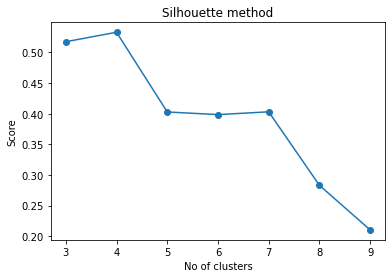

In [137]:
score = []
max_score = 0
k_max = 0
for k in range(3,10):
    modelKM = KMeans(n_clusters=k)
    modelKM.fit(X_pca)
    score.append(silhouette_score(X_pca, modelKM.labels_))
    if silhouette_score(X_pca, modelKM.labels_) > max_score:
        max_score = silhouette_score(X_pca, modelKM.labels_)
        k_max = k
plt.plot(range(3, 10), score, '-o')
plt.title('Silhouette method')
plt.xlabel('No of clusters')
plt.ylabel('Score')
plt.show()

In [138]:
# 4 cluster semblent idéaux pour faire du clustering
fashion_model = KMeans(n_clusters=k_max)
fashion_model.fit(X_pca)
y_km = fashion_model.fit_predict(X_pca)
df_ML_Fashion["cluster"] = y_km # rajouter de la colonne cluster dans le dataframe avant scalé
cp['cluster'] = y_km # rajouter de la colonne cluster dans le dataframe après PCA

In [140]:
# changer le nom des clusters (de 1 à 4)
df_ML_Fashion['cluster'] = df_ML_Fashion['cluster'].apply(lambda x: x+1)
cp['cluster'] = cp['cluster'].apply(lambda x: x+1)

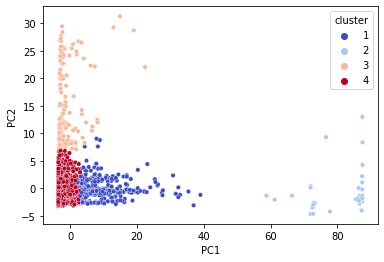

In [141]:
# visualiser les clusters après avoir fait du PCA
sns.scatterplot(x = cp['PC1'], y = cp['PC2'], hue = cp['cluster'], s=20, palette='coolwarm')
plt.show()

In [142]:
df_ML_Fashion.cluster.value_counts()

4    3183
1     476
3     145
2      46
Name: cluster, dtype: int64

In [143]:
df_ML_Fashion.to_csv('df_Fashion_updt.csv')

## Clustering sur la table Cosme ##

In [144]:
df_ML_Cosme = df_ML_Cosme.groupby("user id").agg({"Age" : "first",
                                            "Urbain" : "first",
                                            "Casual, Urbancool, Streetwear, Kawaii" : "first",
                                            "Chic, Smart, Working Girl" : "first",
                                            "Rock, Gothique" : "first",
                                            "Engagée, Made in France" : "first",
                                            "Fatale" : "first",
                                            "Bohême, Romantique" : "first",
                                            "Vintage" : "first",
                                            "Inconnu": "first",
                                            "access_brand": "first",
                                            "mass_brand": "first",
                                            "premium_brand": "first",
                                            "hdg_brand": "first",
                                            "prestige_brand":"first",
                                            "luxe_brand": "first",          
                                            "bio_brand": "first", 
                                            "access_mode": "first",
                                            "mass_market": "first",
                                            "premium_mode": "first",
                                            "hdg_mode": "first",
                                            "prestige_mode": "first",
                                            "luxe_mode": "first",
                                            "vintage_mode": "first",
                                            "eco_responsable_mode": "first",
                                            "like_price" : mean1,
                                            "dislike_price" : mean1,
                                            "like_Naturel" : "sum",
                                            "dislike_Naturel" : "sum",
                                            "like_Synthetique" : "sum",
                                            "dislike_Synthetique" : "sum",
                                            "like_Ecolabel" : "sum",
                                            "dislike_Ecolabel" : "sum",
                                            "like_vif" : "sum",
                                            "dislike_vif" : "sum",
                                            "like_neutre":"sum",
                                            "dislike_neutre" : "sum"})
df_ML_Cosme

,Age,Urbain,"Casual, Urbancool, Streetwear, Kawaii","Chic, Smart, Working Girl","Rock, Gothique","Engagée, Made in France",Fatale,"Bohême, Romantique",Vintage,Inconnu,access_brand,mass_brand,premium_brand,hdg_brand,prestige_brand,luxe_brand,bio_brand,access_mode,mass_market,premium_mode,hdg_mode,prestige_mode,luxe_mode,vintage_mode,eco_responsable_mode,like_price,dislike_price,like_Naturel,dislike_Naturel,like_Synthetique,dislike_Synthetique,like_Ecolabel,dislike_Ecolabel,like_vif,dislike_vif,like_neutre,dislike_neutre
user id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20,49.0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,2,3,0,0,0,0,0,3136.733333,3467.681818,6,4,0,0,18,16,7,0,0,3
21,27.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1965.850000,1268.500000,8,2,0,0,5,1,5,2,3,0
23,24.0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4500.000000,4500.000000,0,0,0,0,24,4,0,0,0,0
71,36.0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,1789.062500,1970.750000,7,3,0,0,3,3,3,4,2,1
126,25.0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,2,0,1,0,0,0,0,0,3033.233333,3608.818182,8,2,0,0,15,19,4,3,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4371,25.0,0,0,3,0,0,0,1,0,0,0,2,0,0,0,0,0,1,2,0,0,0,0,0,0,4500.000000,4500.000000,0,0,0,0,10,18,0,0,0,0
4374,24.0,0,0,1,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4500.000000,4500.000000,0,0,0,0,5,23,0,0,0,0
4377,24.0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,4500.000000,0,0,0,0,0,28,0,0,0,0


In [145]:
df_ML_Cosme1 = df_ML_Cosme.copy()

In [146]:
rb_scaler = RobustScaler() 

df_ML_Cosme1['Age'], \
df_ML_Cosme1['Casual, Urbancool, Streetwear, Kawaii'], \
df_ML_Cosme1['Chic, Smart, Working Girl'], \
df_ML_Cosme1['Rock, Gothique'], \
df_ML_Cosme1['Engagée, Made in France'], \
df_ML_Cosme1['Fatale'], \
df_ML_Cosme1['Bohême, Romantique'], \
df_ML_Cosme1['Vintage'], \
df_ML_Cosme1['Inconnu'], \
df_ML_Cosme1['access_brand'],\
df_ML_Cosme1['mass_brand'],\
df_ML_Cosme1['premium_brand'],\
df_ML_Cosme1['hdg_brand'],\
df_ML_Cosme1['prestige_brand'],\
df_ML_Cosme1['luxe_brand'],\
df_ML_Cosme1['bio_brand'],\
df_ML_Cosme1['access_mode'],\
df_ML_Cosme1['mass_market'],\
df_ML_Cosme1['premium_mode'],\
df_ML_Cosme1['hdg_mode'],\
df_ML_Cosme1['prestige_mode'],\
df_ML_Cosme1['luxe_mode'],\
df_ML_Cosme1['vintage_mode'],\
df_ML_Cosme1['eco_responsable_mode'],\
df_ML_Cosme1['like_price'], \
df_ML_Cosme1['dislike_price'], \
df_ML_Cosme1['like_Naturel'], \
df_ML_Cosme1['dislike_Naturel'], \
df_ML_Cosme1['like_Synthetique'], \
df_ML_Cosme1['dislike_Synthetique'], \
df_ML_Cosme1['like_Ecolabel'], \
df_ML_Cosme1['dislike_Ecolabel'], \
df_ML_Cosme1['like_vif'], \
df_ML_Cosme1['dislike_vif'], \
df_ML_Cosme1['like_neutre'], \
df_ML_Cosme1['dislike_neutre'] = rb_scaler.fit_transform(df_ML_Cosme1[["Age",
                                                                           "Casual, Urbancool, Streetwear, Kawaii",
                                                                           "Chic, Smart, Working Girl",
                                                                           "Rock, Gothique",
                                                                           "Engagée, Made in France",
                                                                           "Fatale",
                                                                           "Bohême, Romantique",
                                                                           "Vintage",
                                                                           "Inconnu",
                                                                            "access_brand",
                                                                            "mass_brand",
                                                                            "premium_brand",
                                                                            "hdg_brand",
                                                                            "prestige_brand",
                                                                            "luxe_brand",          
                                                                            "bio_brand",  
                                                                           "access_mode",
                                                                           'mass_market',
                                                                           'premium_mode',
                                                                           'hdg_mode',
                                                                           'prestige_mode',
                                                                           'luxe_mode',
                                                                           'vintage_mode',
                                                                            'eco_responsable_mode',
                                                                            "like_price",
                                                                            "dislike_price",
                                                                            "like_Naturel",
                                                                            "dislike_Naturel",
                                                                            "like_Synthetique",
                                                                            "dislike_Synthetique",
                                                                            "like_Ecolabel",
                                                                            "dislike_Ecolabel",
                                                                            "like_vif",
                                                                            "dislike_vif",
                                                                            "like_neutre",
                                                                            "dislike_neutre"]]).T

In [147]:
# Faire du PCA avant de faire du clustering
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(df_ML_Cosme1)
pca = PCA(n_components = 0.95)
X_pca = pca.fit_transform(df_ML_Cosme1)
X_pca.shape

(207, 7)

In [148]:
cp_cosme = pd.DataFrame(X_pca, columns =  [f'PC{i}' for i in range(1, (pca.n_components_) + 1)])
cp_cosme

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,-3.444834,0.151507,-1.463179,2.087167,1.735794,3.084730,-0.153123
1,-3.544869,0.312261,-1.324430,-0.333398,0.814903,-0.433238,1.192385
2,-3.742291,0.230932,-1.221950,1.017726,-0.772041,-1.347452,-0.742556
3,-3.156064,-1.607753,-1.732803,0.103144,1.964411,1.105069,0.630842
4,-3.576219,0.241731,-1.137598,-0.477045,0.525816,-0.120227,-0.245623
...,...,...,...,...,...,...,...
202,-3.635030,0.211843,-0.642669,0.962773,-0.801561,-1.063510,-0.490083
203,-3.739359,0.147675,-1.273563,1.011015,-0.336663,-1.315731,-0.764280
204,-3.708652,0.173065,-1.136676,0.489994,-0.498875,-1.061150,-0.380029
205,-3.024936,0.233333,-1.845907,2.668255,0.465626,-0.106047,-0.247158


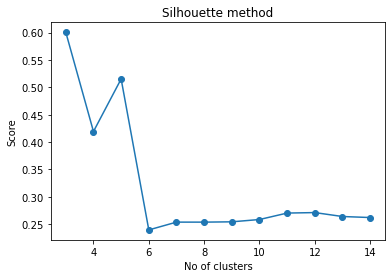

In [149]:
score = []
max_score = 0
k_max = 0
for k in range(3,15):
    modelKM = KMeans(n_clusters=k)
    modelKM.fit(X_pca)
    score.append(silhouette_score(X_pca, modelKM.labels_))
    if silhouette_score(X_pca, modelKM.labels_) > max_score:
        max_score = silhouette_score(X_pca, modelKM.labels_)
        k_max = k
plt.plot(range(3, 15), score, '-o')
plt.title('Silhouette method')
plt.xlabel('No of clusters')
plt.ylabel('Score')
plt.show()

In [151]:
km_model = KMeans(n_clusters=k_max)
km_model.fit(X_pca)
y_km = km_model.fit_predict(X_pca)
df_ML_Cosme["cluster"] = y_km
cp_cosme['cluster'] = y_km

In [152]:
df_ML_Cosme['cluster'] = df_ML_Cosme['cluster'].apply(lambda x: x+1)
cp_cosme['cluster'] = cp_cosme['cluster'].apply(lambda x: x+1)

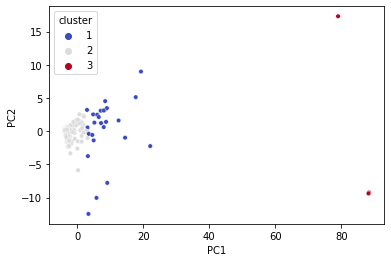

In [153]:
sns.scatterplot(x = cp_cosme['PC1'], y = cp_cosme['PC2'], hue = cp_cosme['cluster'], s=20, palette='coolwarm')
plt.show()

In [154]:
df_ML_Cosme.to_csv('df_Cosme_updt.csv')

## Clustering sur la table Deco ##

In [155]:
df_ML_Deco = df_ML_Deco.groupby("user id").agg({"Age" : "first",
                                            "Urbain" : "first",
                                            "Casual, Urbancool, Streetwear, Kawaii" : "first",
                                            "Chic, Smart, Working Girl" : "first",
                                            "Rock, Gothique" : "first",
                                            "Engagée, Made in France" : "first",
                                            "Fatale" : "first",
                                            "Bohême, Romantique" : "first",
                                            "Vintage" : "first",
                                            "Inconnu": "first",
                                            "access_brand": "first",
                                            "mass_brand": "first",
                                            "premium_brand": "first",
                                            "hdg_brand": "first",
                                            "prestige_brand":"first",
                                            "luxe_brand": "first",          
                                            "bio_brand": "first", 
                                            "access_mode": "first",
                                            "mass_market": "first",
                                            "premium_mode": "first",
                                            "hdg_mode": "first",
                                            "prestige_mode": "first",
                                            "luxe_mode": "first",
                                            "vintage_mode": "first",
                                            "eco_responsable_mode": "first",
                                            "like_price" : mean1,
                                            "dislike_price" : mean1,
                                            "like_Naturel" : "sum",
                                            "dislike_Naturel" : "sum",
                                            "like_Synthetique" : "sum",
                                            "dislike_Synthetique" : "sum",
                                            "like_Ecolabel" : "sum",
                                            "dislike_Ecolabel" : "sum",
                                            "like_vif" : "sum",
                                            "dislike_vif" : "sum",
                                            "like_neutre":"sum",
                                            "dislike_neutre" : "sum"})
df_ML_Deco

,Age,Urbain,"Casual, Urbancool, Streetwear, Kawaii","Chic, Smart, Working Girl","Rock, Gothique","Engagée, Made in France",Fatale,"Bohême, Romantique",Vintage,Inconnu,access_brand,mass_brand,premium_brand,hdg_brand,prestige_brand,luxe_brand,bio_brand,access_mode,mass_market,premium_mode,hdg_mode,prestige_mode,luxe_mode,vintage_mode,eco_responsable_mode,like_price,dislike_price,like_Naturel,dislike_Naturel,like_Synthetique,dislike_Synthetique,like_Ecolabel,dislike_Ecolabel,like_vif,dislike_vif,like_neutre,dislike_neutre
user id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
10,24.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22541.666667,54731.250000,12,16,0,0,0,0,4,3,6,13
12,25.0,0,2,1,0,0,0,1,0,0,0,2,1,0,1,2,0,4,7,4,1,1,2,0,0,24223.809524,32230.000000,15,14,1,3,0,0,7,8,12,12
13,24.0,0,3,3,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1100.000000,445.454545,0,1,1,3,0,0,0,8,2,3
14,24.0,0,1,2,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,655.555556,300.000000,1,0,1,3,0,0,5,3,4,1
15,24.0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,2,0,0,1,1,3,0,1,0,0,700.000000,518.181818,0,1,0,4,0,0,1,7,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4365,34.0,1,2,1,0,0,1,0,0,0,0,0,0,0,0,2,0,0,6,1,0,0,0,0,0,6114.000000,3291.666667,5,0,8,2,0,0,10,2,15,3
4368,24.0,0,1,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5567.741935,0.000000,5,0,10,0,0,0,12,0,18,0
4370,45.0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,8235.294118,2328.571429,3,2,7,3,0,0,9,3,8,10


In [156]:
df_ML_Deco1 = df_ML_Deco.copy()

In [157]:
rb_scaler = RobustScaler() 

df_ML_Deco1['Age'], \
df_ML_Deco1['Casual, Urbancool, Streetwear, Kawaii'], \
df_ML_Deco1['Chic, Smart, Working Girl'], \
df_ML_Deco1['Rock, Gothique'], \
df_ML_Deco1['Engagée, Made in France'], \
df_ML_Deco1['Fatale'], \
df_ML_Deco1['Bohême, Romantique'], \
df_ML_Deco1['Vintage'], \
df_ML_Deco1['Inconnu'], \
df_ML_Deco1['access_brand'],\
df_ML_Deco1['mass_brand'],\
df_ML_Deco1['premium_brand'],\
df_ML_Deco1['hdg_brand'],\
df_ML_Deco1['prestige_brand'],\
df_ML_Deco1['luxe_brand'],\
df_ML_Deco1['bio_brand'],\
df_ML_Deco1['access_mode'],\
df_ML_Deco1['mass_market'],\
df_ML_Deco1['premium_mode'],\
df_ML_Deco1['hdg_mode'],\
df_ML_Deco1['prestige_mode'],\
df_ML_Deco1['luxe_mode'],\
df_ML_Deco1['vintage_mode'],\
df_ML_Deco1['eco_responsable_mode'],\
df_ML_Deco1['like_price'], \
df_ML_Deco1['dislike_price'], \
df_ML_Deco1['like_Naturel'], \
df_ML_Deco1['dislike_Naturel'], \
df_ML_Deco1['like_Synthetique'], \
df_ML_Deco1['dislike_Synthetique'], \
df_ML_Deco1['like_Ecolabel'], \
df_ML_Deco1['dislike_Ecolabel'], \
df_ML_Deco1['like_vif'], \
df_ML_Deco1['dislike_vif'], \
df_ML_Deco1['like_neutre'], \
df_ML_Deco1['dislike_neutre'] = rb_scaler.fit_transform(df_ML_Deco1[["Age",
                                                                           "Casual, Urbancool, Streetwear, Kawaii",
                                                                           "Chic, Smart, Working Girl",
                                                                           "Rock, Gothique",
                                                                           "Engagée, Made in France",
                                                                           "Fatale",
                                                                           "Bohême, Romantique",
                                                                           "Vintage",
                                                                           "Inconnu",
                                                                            "access_brand",
                                                                            "mass_brand",
                                                                            "premium_brand",
                                                                            "hdg_brand",
                                                                            "prestige_brand",
                                                                            "luxe_brand",          
                                                                            "bio_brand",  
                                                                           "access_mode",
                                                                           'mass_market',
                                                                           'premium_mode',
                                                                           'hdg_mode',
                                                                           'prestige_mode',
                                                                           'luxe_mode',
                                                                           'vintage_mode',
                                                                            'eco_responsable_mode',
                                                                            "like_price",
                                                                            "dislike_price",
                                                                            "like_Naturel",
                                                                            "dislike_Naturel",
                                                                            "like_Synthetique",
                                                                            "dislike_Synthetique",
                                                                            "like_Ecolabel",
                                                                            "dislike_Ecolabel",
                                                                            "like_vif",
                                                                            "dislike_vif",
                                                                            "like_neutre",
                                                                            "dislike_neutre"]]).T


In [158]:
pca = PCA()
X_pca = pca.fit_transform(df_ML_Deco1)
pca = PCA(n_components = 0.95)
X_pca = pca.fit_transform(df_ML_Deco1)
X_pca.shape

(2727, 10)

In [159]:
cp_deco = pd.DataFrame(X_pca, columns =  [f'PC{i}' for i in range(1, (pca.n_components_) + 1)])
cp_deco

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-3.229040,-0.836250,0.303021,-1.576317,0.950545,-1.625209,-1.248871,-0.995499,-0.262444,0.100681
1,-1.531900,-0.827617,2.442521,0.461670,0.488906,-1.323974,-0.259739,0.324790,1.715310,0.792155
2,-3.181773,-0.829361,3.775730,-0.621234,0.186104,-3.287991,1.304952,0.051241,2.475228,0.211214
3,-3.168066,-0.734694,3.903465,-0.578949,-0.590149,-2.034285,1.145900,-0.490209,2.241736,0.333911
4,-0.604493,-1.936819,3.764781,-1.120355,0.852085,-3.012098,-0.473963,0.265099,3.729089,0.442131
...,...,...,...,...,...,...,...,...,...,...
2722,-3.003332,-0.793267,8.788696,0.457743,-1.380996,1.350387,-0.032747,0.083690,-2.172100,-0.386514
2723,-3.167406,-0.760870,8.738276,0.771953,-4.509121,0.541136,-0.149128,-0.271332,-4.494926,-1.288147
2724,-2.859071,-0.210344,9.305249,-1.023568,1.654464,1.959336,0.202776,0.473711,-1.398667,-0.119365
2725,-3.121304,-0.727727,6.896418,0.416122,-1.750369,-1.362771,0.854256,-0.528539,1.039110,0.142449


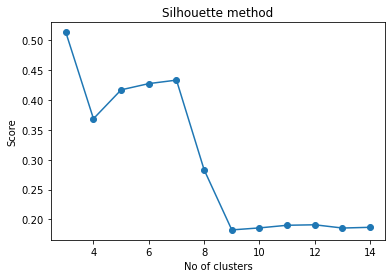

In [160]:
score = []
max_score = 0
k_max = 0
for k in range(3,15):
    modelKM = KMeans(n_clusters=k)
    modelKM.fit(X_pca)
    score.append(silhouette_score(X_pca, modelKM.labels_))
    if silhouette_score(X_pca, modelKM.labels_) > max_score:
        max_score = silhouette_score(X_pca, modelKM.labels_)
        k_max = k
plt.plot(range(3, 15), score, '-o')
plt.title('Silhouette method')
plt.xlabel('No of clusters')
plt.ylabel('Score')
plt.show()

In [161]:
km_model = KMeans(n_clusters=k_max)
km_model.fit(X_pca)
y_km = km_model.fit_predict(X_pca)
df_ML_Deco["cluster"] = y_km
cp_deco['cluster'] = y_km

In [163]:
df_ML_Deco['cluster'] = df_ML_Deco['cluster'].apply(lambda x: x+1)
cp_deco['cluster'] = cp_deco['cluster'].apply(lambda x: x+1)

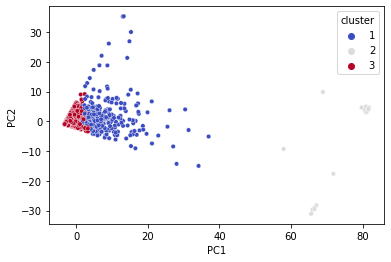

In [164]:
sns.scatterplot(x = cp_deco['PC1'], y = cp_deco['PC2'], hue = cp_deco['cluster'], s=20, palette='coolwarm')
plt.show()

In [165]:
df_ML_Deco.to_csv('df_Deco_updt.csv')

In [170]:
df = df[['campaign_id','action','product name','color','material','user id','zipcode','Age','Département','Coordonnées','Urbain','vif','neutre','type_Campaign']]
df.to_csv('df.csv.zip', index = False, compression = "zip")